In [2]:
import subprocess
import numpy as np
import simplifier
import csv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib as mpl
import sympy
import sys
from scipy.optimize import minimize
rc('text', usetex=True)
rc('axes', titlesize=12, labelsize=12)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

sys.path.insert(0, 'Pantheon/')
import likelihood_cc
import test_all
from filenames import *
from symbols_cc import *

In [3]:
print('Loading data')
xvar, yvar, inv_cov, yerr = likelihood_cc.load_data()
xvar += 1  # now x = 1 + z
print('Loaded')

Loading data
Loaded


	 0 10
	 1 10
	 2 10
	 3 10
	 4 10
	 5 10
	 6 10
	 7 10
	 8 10
	 9 10
7.277102359828813 [0.32616925 0.69649768 0.         0.        ]
0.0 6.5291454844986845


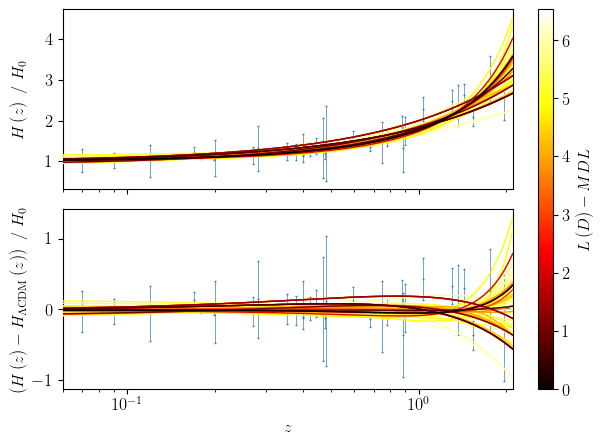

In [12]:
xplot = np.logspace(np.log10(6e-2), np.log10(2.1), 1000) + 1
tmax = 5

# GET LCDM FUNCTION
fcn_i = 'a0 * pow(x, 3) + a1'
fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)

if 'a3' in fcn_i:
    k = 4
    eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
elif 'a2' in fcn_i:
    k = 3
    eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
elif 'a1' in fcn_i:
    k = 2
    eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
elif 'a0' in fcn_i:
    k = 1
    eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
else:
    k = 0
    eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])

chi2, p = test_all.optimise_fun(fcn_i, xvar, yvar, inv_cov, tmax, 0, 4, try_integration=False)
print(chi2, p)

ylcdm_var = likelihood_cc.get_pred(xvar, p[:k], eq_numpy, integrated=integrated)
ylcdm_plot = likelihood_cc.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

# GET OTHER FUNCTIONS
all_compl = np.arange(3, 9)
# all_compl = [3, 4, 5]
# all_compl = [7]
fcn_list = []
all_DL = []
params = []

for i, compl in enumerate(all_compl):
    fname = out_dir + '/final_%i.dat'%compl
    with open(fname, "r") as f:
        reader = csv.reader(f, delimiter=';')
        data = [row for row in reader]
    fcn_list += [d[1] for d in data]
    all_DL += [d[2] for d in data]
    params += [d[7:] for d in data]
    
all_DL = np.array(all_DL, dtype=float)
params = np.array(params, dtype=float)
m = np.isfinite(all_DL)
all_DL = all_DL[m]
params = params[m,:]
fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
MDL = np.amin(all_DL)

# plt.semilogx(np.sort(all_DL - MDL), np.arange(len(all_DL)))

# Take top 50 functions
nfun = 100
idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
all_DL = all_DL[idx] - MDL
params = params[idx,:]
fcn_list = [fcn_list[i] for i in idx]

fig  = plt.figure(figsize=(5,4))
ax1  = fig.add_axes([0.0,0.50,0.9,0.45])
ax2  = fig.add_axes([0.0,0.0,0.9,0.45])
ax3  = fig.add_axes([0.95,0.00,0.03,0.95])
ax1.get_shared_x_axes().join(ax1, ax2)

cmap = cm.hot
vmin = all_DL.min()
vmax = all_DL.max()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
print(vmin, vmax)

max_param = 4
tmax = 5

for i in range(len(fcn_list)):
    
    fcn_i = fcn_list[i].replace('\'', '')

    k = simplifier.count_params([fcn_i], max_param)[0]
    measured = params[i,:k]

#     print('%i of %i:'%(i+1,len(fcn_list)), fcn_i)

    try:
        fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
        ypred_plot = likelihood_cc.get_pred(xplot, measured, eq_numpy, integrated=integrated)
    except:
        fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
        ypred_plot = likelihood_cc.get_pred(xplot, measured, eq_numpy, integrated=integrated)
        
    colour = cmap(norm(all_DL[i]))
    plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}

    ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
    ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)
            
cmvar = plt.get_cmap('Set1')
plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
             'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}
# 'zorder':len(fcn_list)+1

ax1.errorbar(xvar-1, yvar, yerr=yerr, **plot_kwargs)
ax2.errorbar(xvar-1, yvar-ylcdm_var, yerr=yerr, **plot_kwargs)
ax2.axhline(y=0, color=cmvar(1), ls='--')

ax2.set_xlabel(r'$z$')
ax1.set_ylabel(r'$H \left( z \right) \ / \ H_0$')
ax2.set_ylabel(r'$\left( H \left( z \right) - H_{\rm \Lambda CDM} \left( z \right) \right) \ / \ H_0$')

ax1.set_xlim(xplot.min()-1, xplot.max()-1)
ax1.set_xscale('log')
ax1.set_xticklabels([])

cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
cb1.set_label(r'$L \left( D \right) - MDL$')

fig.align_ylabels([ax1, ax2])
fig.tight_layout()

ax1.get_yaxis().set_label_coords(-0.08,0.5)
ax2.get_yaxis().set_label_coords(-0.08,0.5)

fig.savefig('figs/cc_prediction.pdf', bbox_inches='tight', transparent=True)